**Módelo 2**



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline

In [2]:
#Data
df_test = pd.read_csv("/content/drive/MyDrive/GSCred/cs-test.csv", index_col=0)
df_train = pd.read_csv("/content/drive/MyDrive/GSCred/cs-training.csv", index_col=0)
df_train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


<Axes: xlabel='SeriousDlqin2yrs', ylabel='count'>

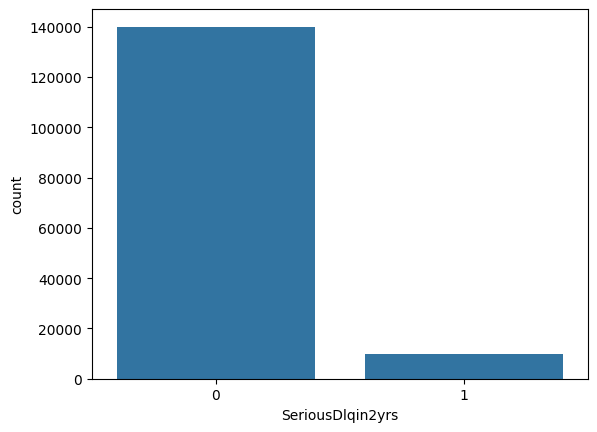

In [3]:
sns.countplot(data=df_train, x='SeriousDlqin2yrs')

In [4]:
from sklearn.model_selection import train_test_split

# Separar la variable objetivo
y = df_train.SeriousDlqin2yrs
X = df_train.drop(['SeriousDlqin2yrs'], axis=1)

# Dividir el conjunto de datos de entrenamiento y prueba
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [5]:
from xgboost import XGBClassifier

# Modelo
model = XGBClassifier(
    learning_rate=0.01,
    n_estimators=100,
    max_depth=6,
    reg_alpha=1,
    reg_lambda=1,
    scale_pos_weight=1,
    objective='binary:logistic',
    random_state=42
) #*
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])


[0]	validation_0-logloss:0.27709
[1]	validation_0-logloss:0.27561
[2]	validation_0-logloss:0.27416
[3]	validation_0-logloss:0.27274
[4]	validation_0-logloss:0.27135
[5]	validation_0-logloss:0.26999
[6]	validation_0-logloss:0.26866
[7]	validation_0-logloss:0.26735
[8]	validation_0-logloss:0.26606
[9]	validation_0-logloss:0.26480
[10]	validation_0-logloss:0.26355
[11]	validation_0-logloss:0.26233
[12]	validation_0-logloss:0.26113
[13]	validation_0-logloss:0.25996
[14]	validation_0-logloss:0.25880
[15]	validation_0-logloss:0.25767
[16]	validation_0-logloss:0.25654
[17]	validation_0-logloss:0.25544
[18]	validation_0-logloss:0.25435
[19]	validation_0-logloss:0.25328
[20]	validation_0-logloss:0.25223
[21]	validation_0-logloss:0.25120
[22]	validation_0-logloss:0.25018
[23]	validation_0-logloss:0.24918
[24]	validation_0-logloss:0.24819
[25]	validation_0-logloss:0.24722
[26]	validation_0-logloss:0.24627
[27]	validation_0-logloss:0.24533
[28]	validation_0-logloss:0.24441
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

model.fit() entrena un modelo de aprendizaje automático en un conjunto de datos de entrenamiento determinado y evalúa su rendimiento en un conjunto de datos de validación. Esto ayuda a garantizar que el modelo pueda generalizarse bien a datos nuevos e invisibles.

In [6]:

X_test = df_test.drop(columns=['SeriousDlqin2yrs'])
pred = model.predict_proba(X_test)[:,1]
pred

array([0.11068362, 0.09648507, 0.0617157 , ..., 0.0617157 , 0.12540786,
       0.07441822], dtype=float32)

In [7]:
from hyperopt import hp, tpe, fmin
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Definir el espacio de busqueda y la funcion objetivo

space = {'n_estimators':hp.quniform('n_estimators', 10, 4000, 10),
        'learning_rate':hp.uniform('learning_rate', 0.00001, 0.03),
         'max_depth':hp.quniform('max_depth', 3,7,1),
         'subsample':hp.uniform('subsample', 0.60, 0.95),
         'colsample_bytree':hp.uniform('colsample_bytree', 0.60, 0.95),
         'reg_lambda': hp.uniform('reg_lambda', 1, 20),
        }
def objective(params):
    params = {'n_estimators': int(params['n_estimators']),
             'learning_rate': params['learning_rate'],
             'max_depth': int(params['max_depth']),
             'subsample': params['subsample'],
             'colsample_bytree': params['colsample_bytree'],
             'reg_lambda': params['reg_lambda'],
             }

    XGBClass= XGBClassifier(**params)
    cv = StratifiedKFold(5)
    score = cross_val_score(XGBClass, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1).mean()
    return -score

In [8]:
best = fmin(fn=objective, space=space, max_evals=20, algo=tpe.suggest)


100%|██████████| 20/20 [34:50<00:00, 104.51s/trial, best loss: -0.865099906394396]


In [9]:
best

{'colsample_bytree': 0.8396185295437053,
 'learning_rate': 0.005566510152452139,
 'max_depth': 4.0,
 'n_estimators': 2320.0,
 'reg_lambda': 3.104583597664072,
 'subsample': 0.6929307892208528}

In [10]:
model_tuned = XGBClassifier(n_estimators=int(best['n_estimators']),
                        colsample_bytree= best['colsample_bytree'],
                        learning_rate= best['learning_rate'],
                        max_depth= int(best['max_depth']),
                        subsample= best['subsample'],
                        reg_lambda= best['reg_lambda']
                       )

model_tuned.fit(X_train, y_train)

pred = model_tuned.predict_proba(X_test)[:,1]
pred

array([0.06605849, 0.05338925, 0.01244136, ..., 0.00549193, 0.06770771,
       0.04108468], dtype=float32)

In [ ]:
#output = pd.DataFrame({'Id': X_test.index,'Probability': pred})
#output.to_csv('submission.csv', index=False)

________________________